In [1]:
from datetime import datetime
import warnings

import ibis
from ibis import common as com
import ibis.expr.datatypes as dt
import pandas as pd
import pymapd
import pytest
from numpy import testing
from IPython.display import display

In [2]:
def cursor2df(cursor):
    col_names = [c.name for c in cursor.description]
    return pd.DataFrame(cursor.fetchall(), columns=col_names)

In [3]:
db_conf = dict(
    host='localhost', port='6274', 
    user='mapd', password='HyperInteractive', 
    database='ibis_testing'
)
'''
db_conf = dict(
    host='metis.mapd.com', user='mapd', password='HyperInteractive',
    port=443, database='mapd', protocol= 'https'
)
'''

def make_mapd_connection(db_conf):
    return ibis.mapd.connect(**db_conf)

mapd = make_mapd_connection(db_conf)

In [4]:
# show database version
mapd.con._client.get_version()

'4.6.1-20190501-1937c23915'

In [5]:
mapd.list_tables()

['diamonds', 'batting', 'awards_players', 'functional_alltypes', 'geo']

In [6]:
branch_name = !cd ~/dev/quansight/ibis-project/ibis && git rev-parse --abbrev-ref HEAD
branch_name = branch_name[0]
branch_name

'add-mapd-window-support'

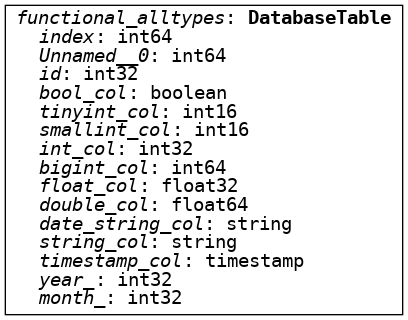

In [7]:
alltypes = mapd.table('functional_alltypes')
alltypes

In [8]:
alltypes.head(5).execute()

,index,Unnamed__0,id,bool_col,tinyint_col,smallint_col,int_col,bigint_col,float_col,double_col,date_string_col,string_col,timestamp_col,year_,month_
0,0,0,6690,True,0,0,0,0,0.0,0.0,11/01/10,0,2010-11-01 00:00:00,2010,11
1,1,1,6691,False,1,1,1,10,1.1,10.1,11/01/10,1,2010-11-01 00:01:00,2010,11
2,2,2,6692,True,2,2,2,20,2.2,20.2,11/01/10,2,2010-11-01 00:02:00,2010,11
3,3,3,6693,False,3,3,3,30,3.3,30.3,11/01/10,3,2010-11-01 00:03:00,2010,11
4,4,4,6694,True,4,4,4,40,4.4,40.4,11/01/10,4,2010-11-01 00:04:00,2010,11


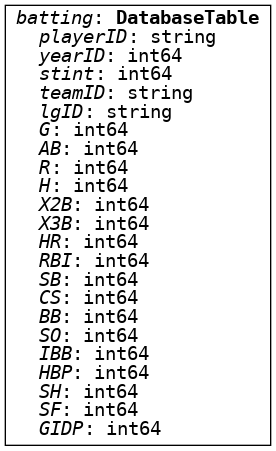

In [9]:
batting = mapd.table('batting')
batting

In [10]:
batting.head(5).execute()

,playerID,yearID,stint,teamID,lgID,G,AB,R,H,X2B,...,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP
0,abercda01,1871,1,TRO,None,1,4,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,addybo01,1871,1,RC1,None,25,118,30,32,6,...,13,8,1,4,0,0,0,0,0,0
2,allisar01,1871,1,CL1,None,29,137,28,40,4,...,19,3,1,2,5,0,0,0,0,0
3,allisdo01,1871,1,WS3,None,27,133,28,44,10,...,27,1,1,0,2,0,0,0,0,0
4,ansonca01,1871,1,RC1,None,25,120,29,39,11,...,16,6,2,2,1,0,0,0,0,0


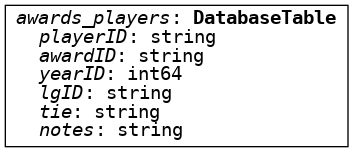

In [11]:
awards_players = mapd.table('awards_players')
awards_players

In [12]:
analytic_alltypes = alltypes.groupby('string_col').order_by('id')
analytic_alltypes

In [13]:
awards_players.head(5).execute()

,playerID,awardID,yearID,lgID,tie,notes
0,bondto01,Pitching Triple Crown,1877,NL,None,None
1,hinespa01,Triple Crown,1878,NL,None,None
2,heckegu01,Pitching Triple Crown,1884,AA,None,None
3,radboch01,Pitching Triple Crown,1884,NL,None,None
4,oneilti01,Triple Crown,1887,AA,None,None


In [14]:
if branch_name == 'add_crossjoin':
    d = alltypes.double_col

    tier = d.histogram(10).name('hist_bin')
    expr = (alltypes.group_by(tier)
    .aggregate([d.min(), d.max(), alltypes.count()])
    .sort_by('hist_bin'))
    print(expr.compile())
    df = expr.execute()
    print(df)
    assert df.size == 40
    assert df['count'][0] == 730

In [15]:
# ??
if branch_name == '':
    t1 = t[t.date_]
    t2 = t[t.price]
    t1.join(t2, ibis.literal(True)).execute()

In [16]:
if branch_name == 'add-union-as-unsupported':
    t = awards_players.sort_by('yearID').limit(10)
    with pytest.raises(com.UnsupportedOperationError):
        t1 = t.head()
        t2 = t.head()
        expr = t1.union(t2)
        
    with pytest.raises(com.UnsupportedOperationError):
        t1 = t
        t2 = t
        expr = t1.union(t2)
        

In [17]:
if branch_name == 'add_literal_null':
    t1 = awards_players.sort_by('yearID').limit(10)
    t2 = batting.sort_by('yearID').limit(10)
    t2 = t2[
        t2.playerID.name('pID'),
        t2.yearID.name('yID'),
        t2.lgID.name('lID'),
        t2.teamID
    ]
    k = [t1, t2.teamID]
    df = t1.left_join(
        t2, (
            (t1.yearID==t2.yID) &
            (t1.playerID==t2.pID) &
            (t1.lgID==t2.lID)
        )
    )[k].materialize().execute()
    print(df)
    print(df.size)
    assert df.size == 80

In [18]:
if branch_name == 'mapd_where_op':
    # expr = ibis.where(table.num > 1, table.num + 10, table.num)
    # expr.execute()
    alltypes = mapd.table('functional_alltypes').sort_by('index').limit(10)
    expr = ibis.where(alltypes.index > 4, 1, 0)
    counts = expr.execute().value_counts()
    assert counts[0] == 5
    assert counts[1] == 5

In [19]:
if branch_name == 'add_geospatial_support':
    test_data = [
        ('point', dt.point),
        ('point;4326', dt.point),
        ('point;4326:geometry', dt.point),
        ('point;4326:geography', dt.point),
        ('linestring', dt.linestring),
        ('linestring;4326', dt.linestring),
        ('linestring;4326:geometry', dt.linestring),
        ('linestring;4326:geography', dt.linestring),
        ('polygon', dt.polygon),
        ('polygon;4326', dt.polygon),
        ('polygon;4326:geometry', dt.polygon),
        ('polygon;4326:geography', dt.polygon),
        ('multipolygon', dt.multipolygon),
        ('multipolygon;4326', dt.multipolygon),
        ('multipolygon;4326:geometry', dt.multipolygon),
        ('multipolygon;4326:geography', dt.multipolygon),
    ]
    for (spec, expected) in test_data:
        assert dt.dtype(spec) == expected

In [20]:
if branch_name == 'fix_todatetime':
    '''
    DTMAX
    SELECT max("timestamp_col") AS t_max
    FROM functional_alltypes
    = 2010-12-31 05:09:13
    ================================================================================
    DTMIN
    SELECT min("timestamp_col") AS t_min
    FROM functional_alltypes
    = 2009-01-01 00:00:00
    '''
    expr = alltypes[alltypes.timestamp_col < datetime.now()]
    print('IBIS-DT_CMP')
    print(expr.compile())
    print('shape:', expr.execute().shape)
    print('=' * 80)
    
    expr = alltypes[alltypes.timestamp_col < '2019-01-14 12:30:21']
    print('IBIS-DT_CMP')
    print(expr.compile())
    print('shape:', expr.execute().shape)
    print('=' * 80)
    
    expr = alltypes[alltypes.timestamp_col < '2019-01-14']
    print('IBIS-DT_CMP')
    print(expr.compile())
    print('shape:', expr.execute().shape)
    print('=' * 80)
    
    
    expr = alltypes[alltypes.timestamp_col < '2019/01/14']
    print('IBIS-DT_CMP')
    print(expr.compile())
    print('shape:', expr.execute().shape)
    print('=' * 80)
    

In [21]:
if branch_name == 'pygdf2cudf':
    conn = mapd.con
    sql = '''
    SELECT *
    FROM functional_alltypes
    WHERE 
      "timestamp_col" < '2009-06-01 00:03:00' 
      AND "timestamp_col" >= '2009-06-01 00:00:00'
    '''
    print('PYMAD')
    print(cursor2df(conn.execute(sql)).head())
    
    dt1 = '2010-01-02'
    dt2 = '2010-01-02 01:02:03'

    dt_value = dt2

    msg = (
        "Literal datetime string should use '%Y-%m-%d %H:%M:%S' format. "
        "When '%Y-%m-%d' format is used, "
        "datetime will be converted automatically to '%Y-%m-%d 00:00:00'"
    )

    try:
        dt = datetime.strptime(dt_value, '%Y-%m-%d %H:%M:%S')
    except ValueError:
        try:
            dt = datetime.strptime(dt_value, '%Y-%m-%d')
            warnings.warn(msg)
        except ValueError:
            dt = None
    if dt is None:
        raise Exception(msg)
    dt.strftime('%Y-%m-%d %H:%M:%S')
    
    db_conf = dict(
        host='localhost', port='9091', 
        user='mapd', password='HyperInteractive', 
        database='ibis_testing',
        execution_type=2
    )
    mapd = ibis.mapd.connect(**db_conf)
    
    mapd.list_tables()
    
    t = mapd.table('functional_alltypes')
    t.head().execute()
    
    t.head().execute()

In [22]:
if branch_name == 'geospatial_functions':
    t = mapd.table('geo')
    display(t)
    print(t.execute())
    print('=' * 80)
    # geo literals declaration
    point_0 = ibis.literal((0, 0), type='point:geometry').name('p')
    point_1 = ibis.literal((1, 1), type='point:geometry').name('p')
    point_2 = ibis.literal((2, 2), type='point;4326:geometry').name('p')
    polygon_0 = ibis.literal((
        ((1, 0), (0, 1), (-1, 0), (0, -1), (1, 0)),
        ((0.1, 0), (0, 0.1), (-0.1, 0),( 0, -0.1), (0.1, 0))
    ), type='polygon')
    # contains
    result = t['geo_linestring'].contains(point_1).execute()
    expected = [True, True, False, False, False]
    testing.assert_almost_equal(result, expected, decimal=2)
    # distance
    result = t['geo_linestring'].distance(point_0).execute()
    expected = [0., 1.41, 2.82, 4.24, 5.66]
    testing.assert_almost_equal(result, expected , decimal=2)
    # area
    arg = polygon_0.area()
    result = t[t, arg.name('tmp')].execute()['tmp']
    expected = [1.98] * 5
    testing.assert_almost_equal(result, expected, decimal=2)
    # length
    result = t['geo_linestring'].length().execute()
    expected = [1.41] * 5
    testing.assert_almost_equal(result, expected , decimal=2)
    # perimeter
    result = t['geo_polygon'].perimeter().execute()
    expected = [5.66] * 5
    testing.assert_almost_equal(result, expected , decimal=2)
    # max-distance
    result = t['geo_linestring'].max_distance(point_0).execute()
    expected = [1.41, 2.82, 4.24, 5.66, 7.08]
    testing.assert_almost_equal(result, expected , decimal=2)
    # x
    result = t['geo_point'].x().execute()
    expected = [0, 1, 2, 3, 4]
    testing.assert_almost_equal(result, expected , decimal=2)
    # y
    result = t['geo_point'].y().execute()
    expected = [0, 1, 2, 3, 4]
    testing.assert_almost_equal(result, expected , decimal=2)
    # x-min
    result = t['geo_linestring'].x_min().execute()
    expected = [0, 1, 2, 3, 4]
    testing.assert_almost_equal(result, expected , decimal=2)
    # x-max
    result = t['geo_linestring'].x_max().execute()
    expected = [1, 2, 3, 4, 5]
    testing.assert_almost_equal(result, expected , decimal=2)
    # y-min
    result = t['geo_linestring'].y_min().execute()
    expected = [0, 1, 2, 3, 4]
    testing.assert_almost_equal(result, expected , decimal=2)
    # y-max
    result = t['geo_linestring'].y_max().execute()
    expected = [1, 2, 3, 4, 5]
    testing.assert_almost_equal(result, expected , decimal=2)
    # start-point
    expr = t['geo_polygon'].contains(t['geo_linestring'].start_point())
    result = t[t, expr.name('tmp')].execute()['tmp']
    expected = [False] * 5
    testing.assert_almost_equal(result, expected , decimal=2)
    # end-point
    expr = t['geo_polygon'].contains(t['geo_linestring'].end_point())
    result = t[t, expr.name('tmp')].execute()['tmp']
    expected = [False] * 5
    testing.assert_almost_equal(result, expected , decimal=2)
    # point-n
    expr = t['geo_polygon'].contains(t['geo_linestring'].point_n(1))
    result = t[t, expr.name('tmp')].execute()['tmp']
    expected = [False] * 5
    testing.assert_almost_equal(result, expected , decimal=2)
    # n-points
    result = t['geo_multipolygon'].n_points().execute()
    expected = [12] * 5
    testing.assert_almost_equal(result, expected , decimal=2)
    #-n-rings
    result = t['geo_multipolygon'].n_rings().execute()
    expected = [4] * 5
    testing.assert_almost_equal(result, expected , decimal=2)
    # srid using field
    result = t['geo_point'].srid().execute()
    expected = [0, 0, 0, 0, 0]
    testing.assert_almost_equal(result, expected , decimal=2)
    # srid using literal
    expr = (point_2.srid() == 4326)
    result = t[t, expr.name('tmp')].execute()['tmp'][[0]]
    expected = [True]
    testing.assert_almost_equal(result, expected , decimal=2)

In [23]:
if branch_name == 'add_client_sql_mapd':
    t = mapd.sql('SELECT index, id FROM functional_alltypes')
    expr = t[t.id < 5]
    print(expr.compile())

In [24]:
if branch_name == 'add-float32-sql-type-names':
    t_name = 'mytable'
    schema = ibis.schema([
        ('a', 'float'), 
        ('b', 'double'), 
        ('c', 'int32'), 
        ('d', 'int64'),
        ('x', 'point'),
        ('y', 'linestring'),
        ('z', 'polygon'),
        ('w', 'multipolygon')
    ])
    mapd.drop_table(t_name, force=True)
    
    try:
        mapd.create_table(t_name, schema=schema)
        t = mapd.table(t_name)
    
        assert isinstance(t.a, ibis.expr.types.FloatingColumn)
        assert isinstance(t.b, ibis.expr.types.FloatingColumn)
        assert isinstance(t.c, ibis.expr.types.IntegerColumn)
        assert isinstance(t.d, ibis.expr.types.IntegerColumn)
        assert isinstance(t.x, ibis.expr.types.PointColumn)
        assert isinstance(t.y, ibis.expr.types.LineStringColumn)
        assert isinstance(t.z, ibis.expr.types.PolygonColumn)
        assert isinstance(t.w, ibis.expr.types.MultiPolygonColumn)
    finally:
        mapd.drop_table(t_name, force=True)

In [25]:
# %xmode

In [28]:
if branch_name == 'add-mapd-window-support':
    '''
    [ ] + rank (minrank)  #  in mapd doesn't allow - 1
    [ ] + row_number  #  in mapd doesn't allow - 1
    [ ] + percent_rank  #  in mapd doesn't allow - 1
    [ ] + ntile  #  in mapd doesn't allow - 1
    [ ] ? cume_dist
    [x] + lag
    [x] + first_value
    [x] + lead
    [x] + last_value
    [x] + mean
    [x] + min
    [x] + max
    [x] + count
    [x] + sum
    '''
    def pd_generic_window(df, fn, g=['string_col'], f='float_col'):
        # fix error on join
        df.string_col = df.string_col.astype(int)
        
        grouped = fn(df.sort_values('id').groupby(g)[g + [f]])
        grouped.rename(columns={f: 'val'}, inplace=True)
        grouped.reset_index(drop=True, inplace=True)
        
        return df.join(
            other=grouped, 
            how='left',
            on=g,
            rsuffix='_'
        )
    
    
    def pd_window_count(df, g=['string_col'], f='float_col'):
        return pd_generic_window(df, lambda v: v.count(), g, f)
    
    
    def pd_window_first(df, g=['string_col'], f='float_col'):
        return pd_generic_window(df, lambda v: v.head(1), g, f)
    
    
    def pd_window_last(df, g=['string_col'], f='float_col'):
        return pd_generic_window(df, lambda v: v.tail(1), g, f)
    
    
    def pd_fn(df, fn):
        column = fn(df.sort_values('id').groupby('string_col'))
        return df.assign(val=column)
    
    
    mapd = make_mapd_connection(db_conf)
    alltypes = mapd.table('functional_alltypes')
    analytic_alltypes = alltypes.groupby('string_col').order_by('id')
    
    params = [
        #lag
        (lambda t: t.float_col.lag(),
         lambda t: pd_fn(t, lambda v: v.float_col.shift(1)),
         False),
        #all
        (lambda t: t.float_col.all(),
         lambda t: pd_fn(t, lambda v: v.float_col.all()),
         True),
        # lead
        (lambda t: t.float_col.lead(),
         lambda t: pd_fn(t, lambda v: v.float_col.shift(-1)),
         True),
        # rank
        (lambda t: t.float_col.rank(),
         lambda t: pd_fn(t, lambda v: v.float_col.rank()),
         True  # rank in mapd doesn't allow - 1
        ),
        # dense rank
        (lambda t: t.float_col.dense_rank(),
         lambda t: pd_fn(t, lambda v: v.float_col.rank(method='dense')),
         True  # rank in mapd doesn't allow - 1
        ),
        # percent rank
        (lambda t: t.float_col.percent_rank(),
         lambda t: pd_fn(t, lambda v: vt.float_col.rank(pct=True)),
         True  # rank in mapd doesn't allow - 1
        ),
        # tile
        (lambda t: t.float_col.ntile(buckets=7),
         lambda t: t.float_col.transform(lambda v: pd.cut(v, 7)),
         True  # tile in mapd doesn't allow - 1
        ),
        # first
        (lambda t: t.float_col.first(),
         lambda t: pd_fn(t, lambda v: v.float_col.transform('head')),
         False  # assert False
        ),
        # last
        (lambda t: t.float_col.last(),
         lambda t: pd_fn(t, lambda v: v.float_col.transform('tail')),
         False),
        (lambda t: t.float_col.first().over(ibis.window(preceding=10)),
         lambda t: t,
         True),
        (lambda t: t.float_col.first().over(ibis.window(following=10)),
         lambda t: t,
         True),
        (lambda t: t.float_col.min(),
         lambda t: pd_fn(t, lambda v: v.float_col.transform('min')),
         False),
        (lambda t: t.float_col.max(),
         lambda t: pd_fn(t, lambda v: v.float_col.transform('max')),
         False),
        (lambda t: t.double_col.sum(),
         lambda t: pd_fn(t, lambda v: v.double_col.transform('cumsum')),
         False),
        (lambda t: t.double_col.mean(),
         lambda t: pd_fn(t, lambda v: v.double_col.transform('mean')),
         False),
        (lambda t: t.double_col.count(),
         lambda t: pd_fn(t, lambda v: v.double_col.cumcount() +1),
         False),
    ]
    for result_fn, expected_fn, skip in params:
        if skip:
            continue
        
        df = alltypes.execute()
        expr = analytic_alltypes.mutate(val=result_fn)
        expected = expected_fn(df).set_index('id').sort_index()

        print('=' * 80) 
        print(expr.compile())
        result = expr.execute().set_index('id').sort_index()

        left, right = result.val, expected.val
        
        try:
            pd.testing.assert_series_equal(left, right)
        except Exception as e:
            print('<' * 80)
            display(left.describe())
            print('=' * 80)
            display(right.describe())
            print('>' * 80)
            raise e

SELECT *,
       lag("float_col") OVER (PARTITION BY "string_col" ORDER BY "id") AS val
FROM functional_alltypes
SELECT *,
       first_value("float_col") OVER (PARTITION BY "string_col" ORDER BY "id") AS val
FROM functional_alltypes
SELECT *,
       last_value("float_col") OVER (PARTITION BY "string_col" ORDER BY "id") AS val
FROM functional_alltypes
SELECT *,
       min("float_col") OVER (PARTITION BY "string_col" ORDER BY "id") AS val
FROM functional_alltypes
SELECT *,
       max("float_col") OVER (PARTITION BY "string_col" ORDER BY "id") AS val
FROM functional_alltypes
SELECT *,
       sum("double_col") OVER (PARTITION BY "string_col" ORDER BY "id") AS val
FROM functional_alltypes
SELECT *,
       avg("double_col") OVER (PARTITION BY "string_col" ORDER BY "id") AS val
FROM functional_alltypes


UnsupportedOperationError: <class 'ibis.expr.operations.Count'> is not supported in window functions

In [ ]:
display(left.describe())
print('=' * 30)
display(right.describe())

In [ ]:
df = alltypes.execute()
print(df.shape)
result = df.sort_values('id').groupby(['string_col', 'double_col']).double_col
for i in result:
    display(pd.DataFrame(i[1]).shape)

In [35]:
!conda install -y statsmodel

Solving environment: failed

PackagesNotFoundError: The following packages are not available from current channels:

  - statsmodel

Current channels:

  - https://conda.anaconda.org/conda-forge/linux-64
  - https://conda.anaconda.org/conda-forge/noarch
  - https://repo.anaconda.com/pkgs/main/linux-64
  - https://repo.anaconda.com/pkgs/main/noarch
  - https://repo.anaconda.com/pkgs/free/linux-64
  - https://repo.anaconda.com/pkgs/free/noarch
  - https://repo.anaconda.com/pkgs/r/linux-64
  - https://repo.anaconda.com/pkgs/r/noarch

To search for alternate channels that may provide the conda package you're
looking for, navigate to

    https://anaconda.org

and use the search bar at the top of the page.




In [34]:
df = alltypes.execute()

import numpy as np
import scipy
import matplotlib.pyplot as plt

norm_cdf = scipy.stats.norm.cdf(df) # calculate the cdf - also discrete

norm_cdf

AttributeError: module 'scipy' has no attribute 'stats'

In [ ]:
# POSTGRESQL
db_psql_conf = {
    'host': 'localhost',
    'port': 5432,
    'user': 'postgres',
    'password': 'postgres',
    'database': 'ibis_testing'
}
psql = ibis.postgres.connect(**db_psql_conf)

In [ ]:
sql = '''
SELECT
       "string_col", lead("double_col") OVER (PARTITION BY "string_col" ORDER BY "id") AS val
FROM functional_alltypes
'''

c = psql.con.execute(sql)
p_all = pd.DataFrame(c.fetchall(), columns=['string_col', 'val'])
m_all = expr = analytic_alltypes.mutate(val=lambda v: v.double_col.lead()).execute()

In [ ]:
# pd.testing.assert_series_equal(p_all.val, result.val.reset_index(drop=True))
pd.testing.assert_series_equal(p_all.val.describe(), m_all.val.describe())
pd.testing.assert_series_equal(
    p_all.sort_values('val').reset_index().val, 
    m_all.sort_values('val').reset_index().val
)

df = alltypes.execute()
expected_fn = lambda t: t.double_col.shift(-1)
column = expected_fn(df.sort_values('id').groupby('string_col'))
expected = df.assign(val=column).set_index('id').sort_index()

pd.testing.assert_series_equal(
    expected.val,
    m_all.set_index('id').sort_index().val
)
m_all.head(10)

In [ ]:
m_df = alltypes.execute()
m_df.sort_values('id').groupby('string_col').double_col.cumcount()

In [ ]:
```test
# test
```

In [ ]:
if branch_name == 'xmn-tests':
    ...